<a href="https://colab.research.google.com/github/jbsher/p4_waste_classification/blob/master/p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
from io import StringIO

from PIL import Image
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l1, l2, l1_l2



Read in

In [4]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The main directory containing the subdirectories of images
train_dir = '/content/drive/MyDrive/DATASET/TRAIN'

# Subdirectories
sub_dirs = ['O', 'R']

# Initialize empty lists to store the images and labels
images = []
labels = []

# Loop over each subdirectory
for sub_dir in sub_dirs:
    # Create full path to subdirectory
    full_dir = os.path.join(train_dir, sub_dir)

    # Get file names in the folder
    image_names = os.listdir(full_dir)

    # Print the number of files in this subdirectory
    print(f'Number of files in {sub_dir} directory:', len(image_names))

    # Loop over the images in the subdirectory
    for image_name in image_names:
        # Construct the full path of the image
        image_path = os.path.join(full_dir, image_name)

        # Read the image from file
        image = cv2.imread(image_path)

        if image is not None:
            # Resize the image to 128x128
            image = cv2.resize(image, (128, 128))

            # Append the image to the images list
            images.append(image)

            # Assign label based on the subdirectory
            if sub_dir == 'O':
                labels.append(0)
            elif sub_dir == 'R':
                labels.append(1)
        else:
            print(f"Failed to load image at {image_path}")

# Convert the list of images to a numpy array
images = np.array(images)

# Normalize the images
images = images / 255.0
print('Images shape:', images.shape)

# Convert the list of labels to a numpy array
labels = np.array(labels)
print('Labels shape:', labels.shape)


Number of files in O directory: 12565
Number of files in R directory: 9999
Images shape: (22564, 128, 128, 3)
Labels shape: (22564,)


In [ ]:
###
# Flatten the images
n_samples = len(images)
flattened_images = images.reshape((n_samples, -1))

# Create a DataFrame
data = {'label': labels}
for i in range(flattened_images.shape[1]):
    data[f'pixel_{i}'] = flattened_images[:, i]

images_df = pd.DataFrame(data)

In [ ]:
#images_df.to_csv('/content/drive/MyDrive/images_df_96.csv')

In [5]:
# Create empty df so dropping doesnt give errors if rerun
images_df = []
images_df = pd.read_csv('/content/drive/MyDrive/images_df_96.csv')


In [ ]:
images_df.drop(columns = 'Unnamed: 0', inplace = True)

In [6]:
# Extract labels and images
images_df.drop(columns = 'Unnamed: 0', inplace = True)
labels = images_df.iloc[:, 0].values
images = images_df.iloc[:, 1:].values

In [7]:
images.shape

(22564, 49152)

In [8]:
def resize_image_array(img_arr, size=(96, 96)):
    # Convert array to Image object.
    img = Image.fromarray((img_arr * 255).astype(np.uint8))

    # Resize image
    img_resized = img.resize(size, Image.LANCZOS)

    # Convert back to array and normalize
    img_array_resized = np.asarray(img_resized) / 255.0
    return img_array_resized

# Reshape your images to 128x128x3
images = images.reshape(-1, 128, 128, 3)

# Now, resize them
images = np.array([resize_image_array(img) for img in images])

# Check the shape of one of your resized images
print(images[0].shape)


(96, 96, 3)


---

BEST PERFORMER

---

In [9]:
# Create a train test split
X = np.array(images)
y = labels

# Split into train and temp (test + validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=42)


print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (20307, 96, 96, 3)
Test set shape: (2257, 96, 96, 3)


In [23]:
model = Sequential()

# Define the data augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=45,       # Rotate the image by up to 40 degrees
    width_shift_range=0.15,  # Shift the image horizontally by up to 20% of the width
    height_shift_range=0.15, # Shift the image vertically by up to 20% of the height
    shear_range=0.1,        # Shear transformation
    zoom_range=0.2,         # Zoom in/out by up to 20%
    horizontal_flip=True,   # Allow random horizontal flip
    fill_mode='nearest'     # Fill in any pixels that might be lost during transformation
)


In [24]:
# First convolutional layer
model.add(Conv2D(64, 3, activation='relu', input_shape=(96, 96, 3)))

# Second convolutional layer
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

# Third convolutional layer
model.add(Conv2D(128, 3, activation='relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(2))

# Fourth convolutional layer
model.add(Conv2D(256, 3, activation='relu'))
model.add(Dropout(0.15))

# Fifth convolutional layer
model.add(Conv2D(128, 3, activation='relu'))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Fit Augmentation
datagen.fit(X_train)


# Create variable for batch size
batch_size = 64

# Model training with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[es],
                    verbose = 1)


Epoch 1/100
317/317 [==============================] - 47s 137ms/step - loss: 0.4983 - accuracy: 0.7705 - val_loss: 0.4188 - val_accuracy: 0.7993
Epoch 2/100
317/317 [==============================] - 43s 136ms/step - loss: 0.4364 - accuracy: 0.8057 - val_loss: 0.3917 - val_accuracy: 0.8325
Epoch 3/100
317/317 [==============================] - 43s 136ms/step - loss: 0.4108 - accuracy: 0.8194 - val_loss: 0.3582 - val_accuracy: 0.8511
Epoch 4/100
317/317 [==============================] - 43s 136ms/step - loss: 0.3881 - accuracy: 0.8310 - val_loss: 0.3719 - val_accuracy: 0.8591
Epoch 5/100
317/317 [==============================] - 43s 136ms/step - loss: 0.3806 - accuracy: 0.8377 - val_loss: 0.3430 - val_accuracy: 0.8604
Epoch 6/100
317/317 [==============================] - 43s 136ms/step - loss: 0.3629 - accuracy: 0.8475 - val_loss: 0.3299 - val_accuracy: 0.8658
Epoch 7/100
317/317 [==============================] - 43s 137ms/step - loss: 0.3514 - accuracy: 0.8541 - val_loss: 0.3422 -

In [25]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)


71/71 [==============================] - 0s 5ms/step - loss: 0.2452 - accuracy: 0.9087


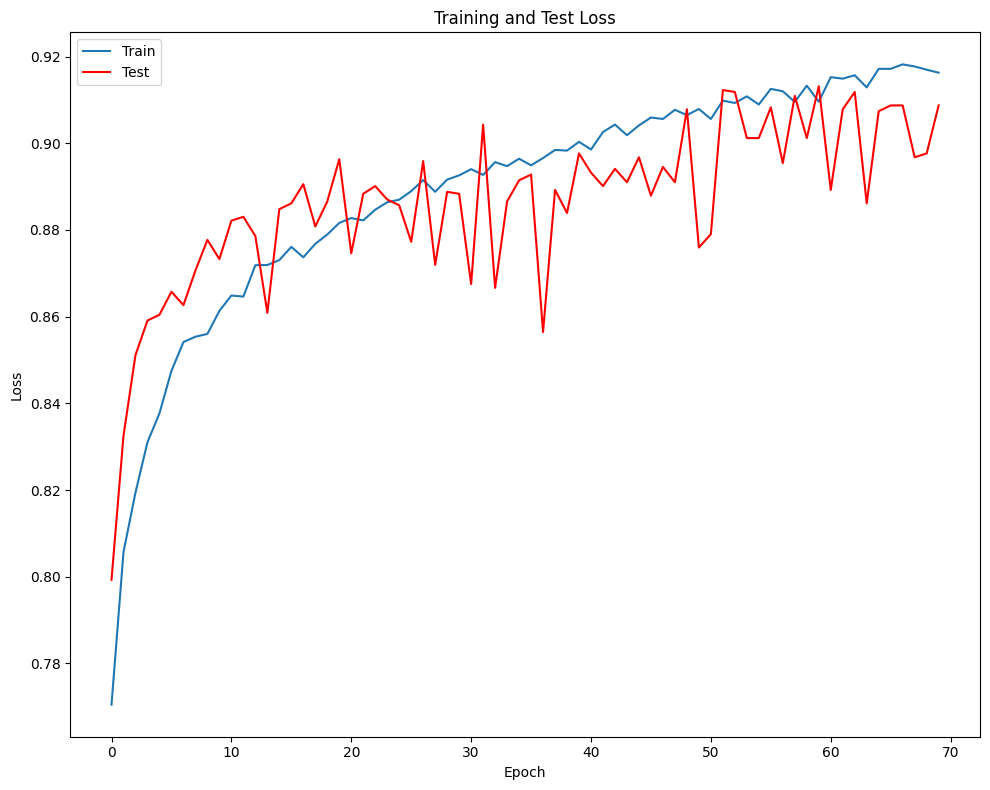

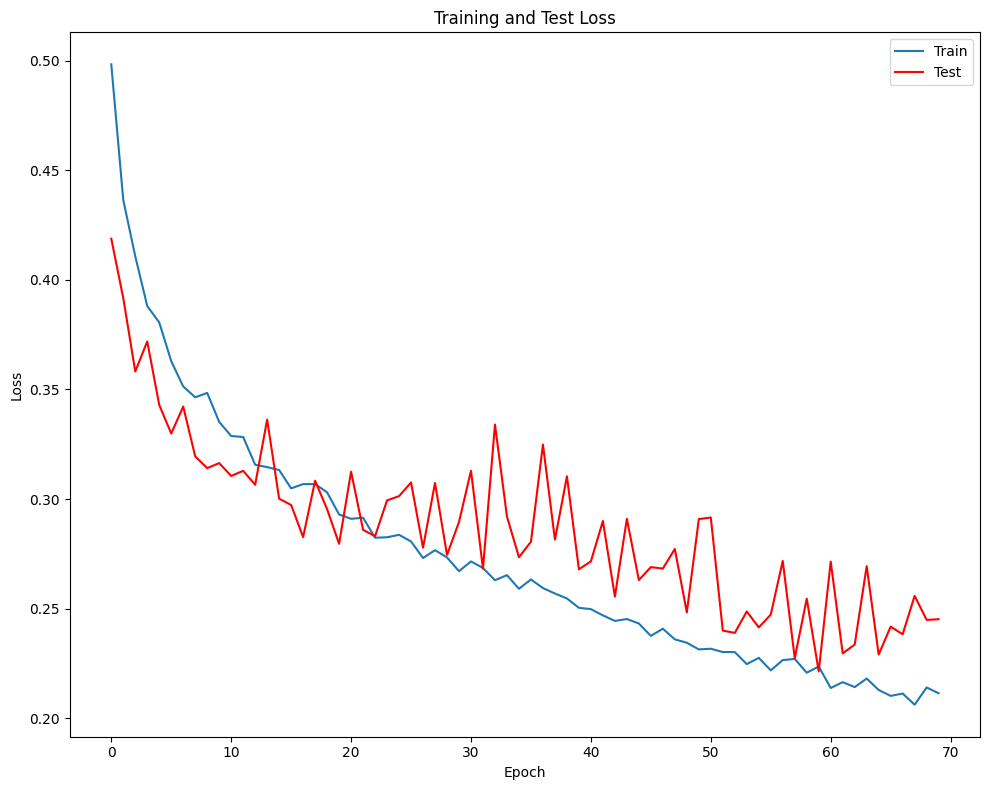

In [26]:
plt.figure(figsize=(10, 8))

# Plot Training and Test Loss
plt.plot(history.history['accuracy'], label='Train')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['val_accuracy'], label='Test', color = 'red')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))

# Plot Training and Test Loss
plt.plot(history.history['loss'], label='Train')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['val_loss'], label='Test', color = 'red')
plt.legend()

plt.tight_layout()
plt.show()

---

TESTING AREA

---

Multiple inputs: Canny Edges, HOG

In [ ]:
# Create a function for canny edges
def apply_canny(images):
    edge_images = []
    for image in images:
        if image.max() > 1.0:
            image = image / 255.0

        # Convert directly to 8-bit
        image_8bit = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray_image, 100, 200)
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        edge_images.append(edges_colored)
    return np.array(edge_images)


In [ ]:
def compute_hog(images):
    win_size = (28, 28)
    block_size = (14, 14)
    block_stride = (7, 7)
    cell_size = (7, 7)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    hog_features = []
    # if it's not yet normalized
    for image in images:
        if image.max() > 1.0:
            image = image / 255.0

        # Convert directly to 8-bit
        image_8bit = (image * 255).astype(np.uint8)
        hog_feature = hog.compute(image_8bit)
        hog_features.append(hog_feature)

    return np.array(hog_features)


In [ ]:
# Try combining other features
model_cnn = Sequential(model) # Replace with your CNN structure

model_cnn.pop()  # Remove last layer

# For all images, get CNN features
cnn_features_train = model_cnn.predict(X_train)
cnn_features_test = model_cnn.predict(X_test)

# Get hog features
hog_features_train = compute_hog(X_train)
hog_features_test = compute_hog(X_test)


# Flatten the cnn features
cnn_features_train_flattened = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_test_flattened = cnn_features_test.reshape(cnn_features_test.shape[0], -1)

# concatenate
combined_features_train = np.concatenate([cnn_features_train_flattened, hog_features_train], axis=1)
combined_features_test = np.concatenate([cnn_features_test_flattened, hog_features_test], axis=1)


# 3. Neural Network for Combined Features:

input_combined = Input(shape=(combined_features_train.shape[1],))
x = Dense(512, activation='relu')(input_combined)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_combined = Model(inputs=input_combined, outputs=output)

# 4. Compilation & Training:

model_combined.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_comb = model_combined.fit(combined_features_train, y_train,
                             epochs=10,
                             validation_data=(combined_features_test, y_test))


177/177 [==============================] - 0s 2ms/step
Epoch 1/10
529/529 [==============================] - 19s 33ms/step - loss: 0.5655 - accuracy: 0.7265 - val_loss: 0.4639 - val_accuracy: 0.8073
Epoch 2/10
529/529 [==============================] - 17s 33ms/step - loss: 0.5087 - accuracy: 0.7480 - val_loss: 0.4910 - val_accuracy: 0.8091
Epoch 3/10
529/529 [==============================] - 17s 33ms/step - loss: 0.4987 - accuracy: 0.7538 - val_loss: 0.4519 - val_accuracy: 0.8156
Epoch 4/10
529/529 [==============================] - 17s 32ms/step - loss: 0.4796 - accuracy: 0.7707 - val_loss: 0.4380 - val_accuracy: 0.8197
Epoch 5/10
529/529 [==============================] - 19s 36ms/step - loss: 0.4719 - accuracy: 0.7810 - val_loss: 0.4665 - val_accuracy: 0.8218
Epoch 6/10
529/529 [==============================] - 17s 32ms/step - loss: 0.4604 - accuracy: 0.7850 - val_loss: 0.4749 - val_accuracy: 0.8204
Epoch 7/10
529/529 [==============================] - 17s 32ms/step - loss: 0.461

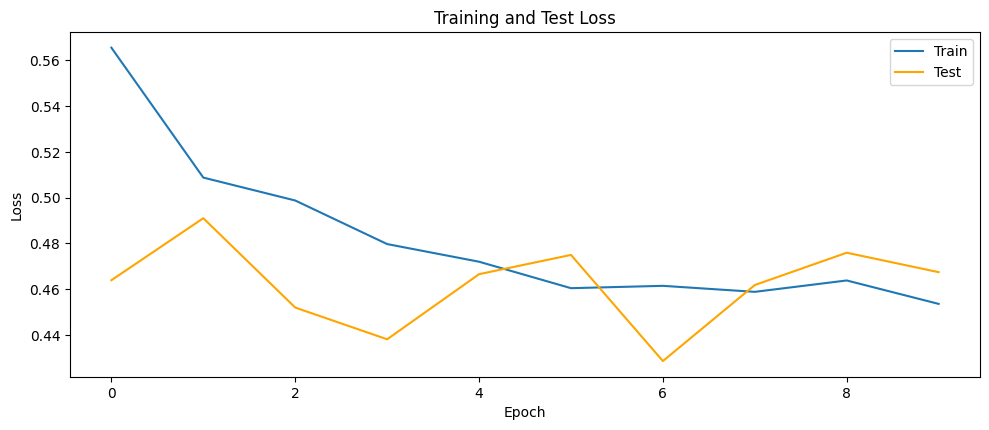

In [ ]:
plt.figure(figsize=(10, 8))

# Plot Training Loss
plt.subplot(2, 1, 1)
plt.plot(history_comb.history['loss'], label='Train')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history_comb.history['val_loss'], label='Test', color = 'orange')
plt.legend()

plt.tight_layout()
plt.show()

SAFETY MODEL

In [ ]:
# First convolutional layer
model.add(Conv2D(64, 3, activation='relu', input_shape=(28, 28, 3)))

# Second convolutional layer
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))

# Third convolutional layer
model.add(Conv2D(128, 3, activation='relu'))
model.add(Dropout(0.15))
model.add(MaxPooling2D(2))

# Fourth convolutional layer
model.add(Conv2D(256, 3, activation='relu'))
model.add(Dropout(0.15))

# Fifth convolutional layer
model.add(Conv2D(128, 3, activation='relu'))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping callback
es = EarlyStopping(monitor='val_loss', patience=5)

# Fit Augmentation
datagen.fit(X_train)


# Create variable for batch size
batch_size = 64

# Model training with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    callbacks=[],
                    verbose = 1)


In [ ]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)


142/142 [==============================] - 1s 5ms/step - loss: 0.3465 - accuracy: 0.8540


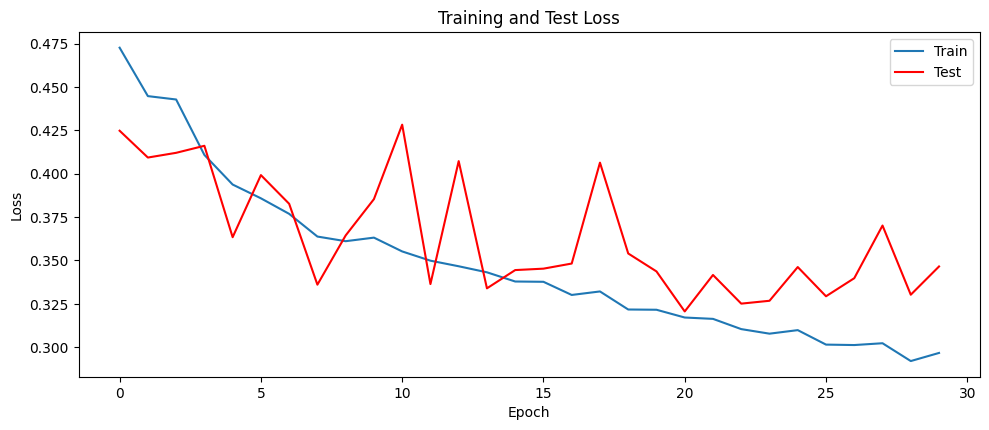

In [ ]:

plt.figure(figsize=(10, 8))

# Plot Training Loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['val_loss'], label='Test', color = 'red')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Set up ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=5, min_lr=0.001)